<a href="https://colab.research.google.com/github/YinYinTan/CIND820FinalProject/blob/main/6a_XGBoost_Classification_Models_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# eXtreme Gradient Boosting (XGBoost) Classification Models using Working Dataset with Principal Components

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import time

In [ ]:
#Read file
df = pd.read_csv('3b. Working Dataset - PCA.csv', index_col=None)

# 1. All Principal Components in Working Dataset - Evaluation using Train-Test Split

In [ ]:
#Split dataframe, using 80% for training and 20% for testing
from sklearn.model_selection import train_test_split

X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

In [ ]:
#Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
smote = SMOTE(random_state = 888)
X_train, y_train = smote.fit_resample(X_train, y_train)

#XGBoost classification model

t1 = time.perf_counter() #time counter start

model = XGBClassifier(random_state=888)
model.fit(X_train, y_train)

y_pred=model.predict(X_test)

t2 = time.perf_counter() #time counter ends

#Save results into dictionary
xgb_all_base_pca = {'Accuracy':metrics.accuracy_score(y_test, y_pred), 'Precision':metrics.precision_score(y_test, y_pred),'Recall':metrics.recall_score(y_test, y_pred),\
          'F1-Score':metrics.f1_score(y_test, y_pred),'AUC':metrics.roc_auc_score(y_test, y_pred),'Brier Score':metrics.brier_score_loss(y_test, y_pred),'Execution Time (sec)':int(t2-t1)}

#Evaluation of XGBoost classification model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))
print('Execution time in seconds:', int(t2-t1))

Accuracy: 0.6391454965357968
Precision: 0.7927835051546391
Recall: 0.644593461860855
F1-score: 0.7110494683310217
Area Under Curve (AUC): 0.6358403301883124
Brier Score: 0.3608545034642032
Execution time in seconds: 3


# 2. All Principal Components in Working Dataset - Hyperparameter Tuning

### 2.1 Random Search with Cross Validation
In this section, a grid of hyperparameter ranges will be defined, and randomly sampled from the grid, where k-fold cross validation will be performed with each combination of values.

In [ ]:
from pprint import pprint

#Look at parameters currently used by the model
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 888,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}


The following set of hyperparameters will be adjusted to narrow down the best combination of parameters:
*   learning_rate: step size shrinkage used to prevent overfitting (range is 0 to 1). Makes the model more robust by shrinking the weights on each step.
Typical values used are 0.01 to 0.2.
*   min_child_weight = minimum sum of weights of all observations required in a child, used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. High values can lead to under-fitting.
*   max_depth = how deeply each tree is allowed to grow during any boosting round. Used to control over-fitting as higher depths will allow models to learn relations very specific to a particular sample.
*   gamma = the minimum loss reduction required to make a split
*   subsample = percentage of samples used per tree (a low value prevents overfitting, but values that are too small can lead to underfitting)
*   colsample_bytree = percentage of features used per tree (a high value can lead to overfitting)
*   n_estimators = number of trees to build
*   reg_alpha = regularization term on weight. Can be used in case of very high dimensionality so that the algorithm runs faster when implemented

In [ ]:
#Creation of a parameter grid to sample from during fitting. On each iteration, the algorithm will choose a different, random combination of parameter values.

from sklearn.model_selection import RandomizedSearchCV

# Step size shrinkage used to prevent overfitting
learning_rate = [0.01, 0.2]

# Minimum sum of weights of all observations required in a child
min_child_weight = range(1,6,2)

# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50]

# Minimum loss reduction required to make a split
gamma = [i/10.0 for i in range(0,5)]

# Percentage of samples used per tree
subsample = [i/10.0 for i in range(6,10)]

# Percentage of features used per tree
colsample_bytree = [i/10.0 for i in range(6,10)]

# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]

# Regularization
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]

# Create the random grid
random_grid = {'learning_rate': learning_rate,
               'min_child_weight': min_child_weight,
               'max_depth': max_depth,
               'gamma': gamma,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               'n_estimators': n_estimators,
               'reg_alpha': reg_alpha}

pprint(random_grid)

{'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'learning_rate': [0.01, 0.2],
 'max_depth': [10, 20, 30, 40, 50],
 'min_child_weight': range(1, 6, 2),
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000],
 'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
 'subsample': [0.6, 0.7, 0.8, 0.9]}


In [ ]:
#Using the random grid to search for best parameters

#Create the base model to tune
model = XGBClassifier(random_state=888)

#Random search of parameters across 50 different combinations, using 3 fold cross validation
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 50, cv = 3, scoring = 'recall', verbose=2, random_state=42, n_jobs = -1)

#Fit the random search model
model_random.fit(X_train, y_train)

#View the best parameters from fitting the random search (based on model with the best recall)
model_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'colsample_bytree': 0.8,
 'gamma': 0.1,
 'learning_rate': 0.01,
 'max_depth': 40,
 'min_child_weight': 1,
 'n_estimators': 911,
 'reg_alpha': 0.1,
 'subsample': 0.7}

In [ ]:
#Evaluation of best model from random search
best = model_random.best_estimator_
y_pred=best.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))

Accuracy: 0.667147806004619
Precision: 0.7498986623429267
Recall: 0.7753562447611064
F1-score: 0.7624150010302906
Area Under Curve (AUC): 0.6015000147738742
Brier Score: 0.3328521939953811


Compared to the default XGBoost parameters used in the prior "All Principal Components in Working Dataset - Evaluation using Train-Test Split" section, the best model from the grid search resulted in a 13.1% increase in Recall (the metric chosen for scoring).
*   Accuracy, F1-score, and Brier Score also improved.
*   Accuracy increased by 2.8%, the F1-score increased by 5.1%, and the Brier Score decreased by 2.8%.
*   Precision and AUC decreased slightly by 4.3% and 3.4%, respectively.

The best model found in the random search has the same values for 1 of the 8 parameters as the default model (i.e. min_child_weight = 1).

### 2.2 Grid Search with Cross Validation
The random search above narrowed down the range for each hyperparameter. In this section, every combination of settings is defined.

In [ ]:
from sklearn.model_selection import GridSearchCV

#Create the parameter grid based on the results of previous random search. This will try out 3 * 1 * 1 * 3 * 1 * 1 * 2 * 3 = 54 combinations of settings.
param_grid = {'learning_rate': [0.01, 0.05, 0.1],
               'min_child_weight': [1],
               'max_depth': [40],
               'gamma': [0.05, 0.1, 0.15],
               'subsample': [0.7],
               'colsample_bytree': [0.8],
               'n_estimators': [800, 900],
               'reg_alpha': [0.05, 0.1, 0.5]}

#Create the base model to tune
model = XGBClassifier(random_state=888)

#Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, scoring = 'recall', n_jobs = -1, verbose = 2)

#Fit the grid search model
grid_search.fit(X_train, y_train)

#View the best parameters from fitting the grid search (based on model with the best recall)
grid_search.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


{'colsample_bytree': 0.8,
 'gamma': 0.05,
 'learning_rate': 0.01,
 'max_depth': 40,
 'min_child_weight': 1,
 'n_estimators': 800,
 'reg_alpha': 0.05,
 'subsample': 0.7}

In [ ]:
#Evaluate performance of best model from grid search
best = grid_search.best_estimator_
y_pred=best.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))

Accuracy: 0.6963048498845266
Precision: 0.7244279946164199
Recall: 0.902347024308466
F1-score: 0.8036580813736469
Area Under Curve (AUC): 0.5713033822841032
Brier Score: 0.30369515011547343


Compared to the default XGBoost parameters used in the prior "All Features in Working Dataset - Evaluation using Train-Test Split" section, the best model from the random search resulted in a large 25.8% increase in Recall (the metric chosen for scoring).
*   Accuracy, F1-score, and Brier Score also improved.
*   Accuracy increased by 5.7%, the F1-score increased by 9.3%, and the Brier Score decreased by 5.7%.
*   Precision and AUC decreased by 6.8% and 6.5%, respectively.

# 3. All Features in Working Dataset, Using Parameters from Grid Search - Evaluation using Repeated 10-fold Cross Validation

In [ ]:
X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

#Set cross-validation to 10-folds, repeated 3 times
folds = 10
repeats = 3
rkf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats)

#XGBoost classification model
model = XGBClassifier(colsample_bytree=0.8, gamma=0.05, learning_rate=0.01, max_depth=40, min_child_weight=1, n_estimators=800, reg_alpha=0.05, subsample=0.7)

#Performance metrics
accuracy = precision = recall = f1 = auc = brier = ex_time = 0

for train_index, test_index in rkf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE()
  X_train, y_train = smote.fit_resample(X_train, y_train)

  t1 = time.perf_counter() #time counter start

  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  t2 = time.perf_counter() #time counter ends

  accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
  precision = precision + metrics.precision_score(y_test, y_pred)
  recall = recall + metrics.recall_score(y_test, y_pred)
  f1 = f1 + metrics.f1_score(y_test, y_pred)
  auc = auc + metrics.roc_auc_score(y_test, y_pred)
  brier = brier + metrics.brier_score_loss(y_test, y_pred)
  ex_time = ex_time + t2-t1

#Save results into dictionary
xgb_all_tuned_pca = {'Accuracy':accuracy/(folds*repeats), 'Precision':precision/(folds*repeats),'Recall':recall/(folds*repeats),\
          'F1-Score':f1/(folds*repeats),'AUC':auc/(folds*repeats),'Brier Score':brier/(folds*repeats),'Execution Time (sec)':ex_time/(folds*repeats)}

#Evaluation of XGBoost classification model
print("Accuracy:", accuracy/(folds*repeats))
print("Precision:", precision/(folds*repeats))
print("Recall:", recall/(folds*repeats))
print("F1-score:", f1/(folds*repeats))
print("Area Under Curve (AUC):", auc/(folds*repeats))
print("Brier Score:", brier/(folds*repeats))
print('Execution time in seconds:', ex_time/(folds*repeats))

Accuracy: 0.6682446146860513
Precision: 0.7553335567697148
Recall: 0.7667588102484476
F1-score: 0.7609506970770661
Area Under Curve (AUC): 0.608487630232449
Brier Score: 0.3317553853139485
Execution time in seconds: 217.45120371689973


# 4A. Selected Features - Filter Method

## 4.1 Top Principal Components
It was decided to build XGBoost models using the top 1 to all principal components to compare performance.

In [ ]:
#Build classification model using 1 to all of the principal components and compare performance on Recall

recall_test = []
components = len(df.columns)

for n in range(1, components):

  #Split dataframe, using 80% for training and 20% for testing
  #Only select top n variables for X
  X = df.iloc[:,:n]
  y = df['Worse_MH']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  #SVM classification model, using the parameters identified during hyperparameter tuning
  model = XGBClassifier(colsample_bytree=0.8, gamma=0.05, learning_rate=0.01, max_depth=40, min_child_weight=1, n_estimators=800, reg_alpha=0.05, subsample=0.7, random_state=888)
  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  #Save results into list
  recall_test.append(metrics.recall_score(y_test, y_pred))

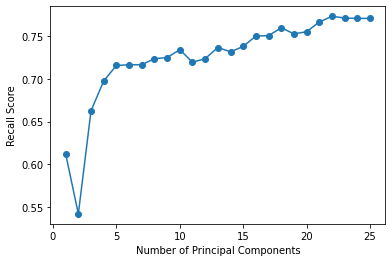

In [ ]:
#Plot recall scores against number of features used
plt.plot(range(1,components), recall_test, marker='o')
plt.ylabel('Recall Score')
plt.xlabel('Number of Principal Components')
plt.show()

Based on the plot above, it appears that model performance increases as more principal components are used, until 22 components are reached. After that,Recall performance plateaus.

## 4.2 Top 22 Principal Components, Filter Method - Evaluation using Repeated 10-fold Cross Validation
Based on the results above, it was decided to build a XGBoost model using the top 22 principal components.

In [ ]:
#Only select top 22 components for X
X = df.iloc[:,:22]
y = df['Worse_MH']

In [ ]:
#Set cross-validation to 10-folds, repeated 3 times
folds = 10
repeats = 3
rkf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats)

#XGBoost classification model, using the parameters identified during hyperparameter tuning
model = XGBClassifier(colsample_bytree=0.8, gamma=0.05, learning_rate=0.01, max_depth=40, min_child_weight=1, n_estimators=800, reg_alpha=0.05, subsample=0.7)

#Performance metrics
accuracy = precision = recall = f1 = auc = brier = ex_time = 0

for train_index, test_index in rkf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  #Apply Synthetic Mifilnority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE()
  X_train, y_train = smote.fit_resample(X_train, y_train)

  t1 = time.perf_counter() #time counter start

  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  t2 = time.perf_counter() #time counter ends

  accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
  precision = precision + metrics.precision_score(y_test, y_pred)
  recall = recall + metrics.recall_score(y_test, y_pred)
  f1 = f1 + metrics.f1_score(y_test, y_pred)
  auc = auc + metrics.roc_auc_score(y_test, y_pred)
  brier = brier + metrics.brier_score_loss(y_test, y_pred)
  ex_time = ex_time + t2-t1

#Save results into dictionary
xgb_22_tuned_pca = {'Accuracy':accuracy/(folds*repeats), 'Precision':precision/(folds*repeats),'Recall':recall/(folds*repeats),\
          'F1-Score':f1/(folds*repeats),'AUC':auc/(folds*repeats),'Brier Score':brier/(folds*repeats),'Execution Time (sec)':ex_time/(folds*repeats)}

#Evaluation of XGBoost classification model
print("Accuracy:", accuracy/(folds*repeats))
print("Precision:", precision/(folds*repeats))
print("Recall:", recall/(folds*repeats))
print("F1-score:", f1/(folds*repeats))
print("Area Under Curve (AUC):", auc/(folds*repeats))
print("Brier Score:", brier/(folds*repeats))
print('Execution time in seconds:', ex_time/(folds*repeats))

Accuracy: 0.6644148456195917
Precision: 0.7553692116900464
Recall: 0.7584322745845923
F1-score: 0.756849629289127
Area Under Curve (AUC): 0.607385586890317
Brier Score: 0.33558515438040815
Execution time in seconds: 194.9798847585332


The model performed better than the base model in section 1, and less than 1% worse for all metrics compared to the tuned model using all principal components (section 4.1).

# 5. Comparison of Models

In [ ]:
#Combine performance metrics for all models into one dataframe
comparison = pd.DataFrame([xgb_all_base_pca, xgb_all_tuned_pca, xgb_22_tuned_pca], index=['XGBoost All Components - Base (PCA)','XGBoost All Components - Tuned (PCA)','XGBoost 22 Components - Tuned (PCA)'])
comparison

,Accuracy,Precision,Recall,F1-Score,AUC,Brier Score,Execution Time (sec)
XGBoost All Components - Base (PCA),0.639145,0.792784,0.644593,0.711049,0.635840,0.360855,3.000000
XGBoost All Components - Tuned (PCA),0.668245,0.755334,0.766759,0.760951,0.608488,0.331755,217.451204
XGBoost 22 Components - Tuned (PCA),0.664415,0.755369,0.758432,0.756850,0.607386,0.335585,194.979885


'XGBoost All Components - Tuned (PCA)', the XGBoost model using all features and the parameters identified during hyperparameter tuning, had the best Accuracy, Recall, F1-Score, and Brier Score. However, it's performance was within 1% for all metrics compared to the 'XGBoost 22 Components - Tuned (PCA)'. Since the best model had a reasonable execution time of 217 seconds, it was selected as the best model to use.

# 6. Stability of Best Model by Varying k-folds for Cross Validation

The stability of the best model identified above was tested by performing repeated k-folds cross-validation, with values of k from 5 to 12, and 2 repeats.
*   Originally, values of k from 3 to 15 were used, and the number of repeats was set to 3, but execution runtime exceeded 5 hours before the decision was made to interrupt execution. Thus, values of k and the number of repeats were then changed to reduce runtime.

In [ ]:
X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

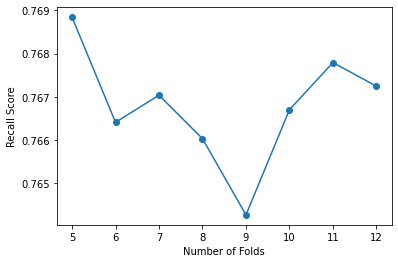

Range of Recall Scores: 0.4568569752266938


In [ ]:
recall_test = []

for k in range(5, 13):
  #Set cross-validation to k-folds, repeated 2 times.
  #Originally, the number of repeats was set to 3, but execution runtime exceeded 5 hours before the decision was made to interrupt execution. Thus, the number of repeats was changed to reduce runtime.
  repeats = 2
  rkf = RepeatedStratifiedKFold(n_splits=k, n_repeats=repeats)

  #Best XGBoost classification model identified in section 5, 'XGBoost All Components - Tuned (PCA)'
  model = XGBClassifier(colsample_bytree=0.8, gamma=0.05, learning_rate=0.01, max_depth=40, min_child_weight=1, n_estimators=800, reg_alpha=0.05, subsample=0.7)

  #Performance metrics
  recall = 0

  for train_index, test_index in rkf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)

    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)

    recall = recall + metrics.recall_score(y_test, y_pred)

  #Calculate average recall, append to list
  recall_test.append(recall/(k*repeats))

#Plot recall scores against number of folds used
plt.plot(range(5, 13), recall_test, marker='o')
plt.ylabel('Recall Score')
plt.xlabel('Number of Folds')
plt.show()

print("Range of Recall Scores:", (max(recall_test)-min(recall_test))*100)

The model appears to be quite stable, with Recall ranging by less than 1%.